In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path
from typing import List

import torch
import torch.nn as nn

# add current directory to path
sys.path.append(os.path.join(os.getcwd(), "llama"))

from llama import Llama

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ds import DART

os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12357"
os.environ["NUM_TRAINERS"] = "1"

/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the LLAMA model

model_name = "llama"
max_seq_len = 128
max_batch_size = 4
generator = Llama.build(
        ckpt_dir=f"../{model_name}/META_RELEASED_WEIGHTS/7B",
        tokenizer_path=f"../{model_name}/META_RELEASED_WEIGHTS/tokenizer.model",
        max_seq_len=max_seq_len,
        max_batch_size=max_batch_size,
        model_parallel_size=1,
    )
generator.model = generator.model.half()
for n, p in generator.model.named_parameters():
    p.requires_grad = False

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 5.57 seconds


In the text, we had two important observations about the limitations of prefix-tuning. Namely:

1. __Prefix tuning cannot change the attention distribution across the non-prefix positions.__ It just "steals" attention from the non-prefix positions, leaving them scaled down but with the same relative attention distribution.

2. __Prefix tuning can only apply a bias to the activations of the non-prefix positions.__ We showed that the effect of prefix-tuning is limited to biasing the activations in a fixed direction, with the attention on the prefix governing the strength of the bias.

In this notebook, we show that these two phenomena occur in practice in the LLAMA model.

In [46]:
# load a dataset and a prefix tuned for it
ds = DART("test")

# You need to download the trained prefix from the provided Google Drive link
prefix = torch.load("llama-7B_DART_Classic_1_1_20230920_223226_9.pt", map_location="cuda")["prefix"]
prefix_size, n_dim = prefix.shape[1], prefix.shape[2]
print(f"Loaded a prefix of length {prefix_size} with {n_dim} dimensions")

Found cached dataset dart (/homes/cdt21/aleks/.cache/huggingface/datasets/dart/default/0.0.0/bbf058468e494e171c5731ee18aa81f340fca22c46f8d3726fc7335d721052a3)
[nltk_data] Downloading package wordnet to
[nltk_data]     /homes/cdt21/aleks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /homes/cdt21/aleks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /homes/cdt21/aleks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loaded a prefix of length 1 with 4096 dimensions


In [87]:
dummy_prefix = " ".join(["X"]*prefix_size) # we pass this to the input for the positions where we hard-code the prefix


sample_idx = 104 # which sample from the dataset to take
sentence = dummy_prefix + " TABLE: " + ds[sample_idx][0] + " TEXT: "+ds[sample_idx][1][0]
print("Test sentence:")
print(sentence)

all_tokens = generator.tokenizer.encode(sentence, bos=False, eos=False)
assert len(all_tokens) < max_seq_len, "The sentence doesn't fit in the maximum context size"

# get the attention patterns, inputs and activations with the prefix
with torch.no_grad(), torch.autocast(
    device_type="cuda", dtype=torch.float16
):
    _ = generator.model.forward(
        tokens=torch.tensor([all_tokens]), 
        prefix=prefix,
        start_pos=0,
    )
    attention_with_prefix = generator.model.layers[0].attention.last_attention
    activations_with_prefix = generator.model.layers[0].attention.last_output

    # and without the prefix
    tokens_wo_prefix = all_tokens[prefix_size:]
    _ = generator.model.forward(
        tokens=torch.tensor([tokens_wo_prefix]), 
        start_pos=0,        
    )
    attention_wo_prefix = generator.model.layers[0].attention.last_attention
    activations_wo_prefix = generator.model.layers[0].attention.last_output

Test sentence:
X TABLE: Fourth Round Qualifying : NEW_ENTRIES_THIS_ROUND : 24 TEXT: Fourth round qualifying had 24 new entries.


Let's check that the attention patterns of the content are simply scaled down by the presence of the prefix but their relative attention is the same.

We show the attention map for the case with and without the prefix. We consider the first layer because the effect of the prefix is compounded in the deeper layers and the analysis is more difficult. The same results how though for layer $i$ if comparing layer $i$ with prefix and without prefix, given that layers $0, \ldots, i-1$ are fixed (i.e., all have a prefix or none have a prefix in both cases).

In [68]:
attention_with_prefix.shape

torch.Size([1, 32, 39, 39])

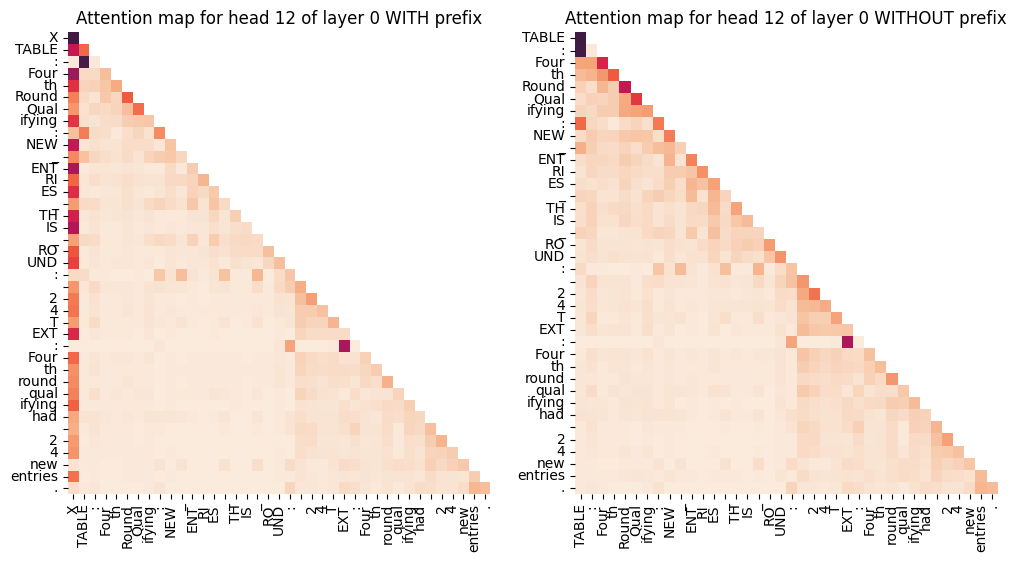

In [100]:
layer_idx = 0
head_idx = 12

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

attention_map_with = attention_with_prefix[0, head_idx].detach().cpu().numpy()
words_with = [generator.tokenizer.decode([w]) for w in all_tokens]
sns.heatmap(
    attention_map_with, 
    vmin=0, vmax=1, 
    xticklabels=words_with, yticklabels=words_with,
    mask=np.triu(np.ones_like(attention_map_with), k=1), 
    ax=ax1, 
    cbar=False,
    center=0.6,
    cmap="rocket_r",
)
ax1.set_title(f"Attention map for head {head_idx} of layer {layer_idx} WITH prefix")

attention_map_wo = attention_wo_prefix[0, head_idx].detach().cpu().numpy()
words_wo = [generator.tokenizer.decode([w]) for w in tokens_wo_prefix]
sns.heatmap(
    attention_map_wo, 
    vmin=0, vmax=1, 
    xticklabels=words_wo, yticklabels=words_wo, 
    mask=np.triu(np.ones_like(attention_map_wo), k=1),
    ax=ax2, 
    cbar=False,
    center=0.6,
    cmap="rocket_r",
)
ax2.set_title(f"Attention map for head {head_idx} of layer {layer_idx} WITHOUT prefix")
plt.savefig("llama_with_prefix.pdf")
plt.show()

Visually, the patterns across the non-prefix tokens looks the same, but let's check that the numerical values, after being appropriatly scaled to account for the attention on the prefix, also match.

In particular we want to show that

$$ A_{ij}^\text{pt} =  A_{ij} (1-A_{i0}^\text{pt}). $$

The left-hand side is `attention_map_with` which we already have, now we will compute the right hand side and call it `scaled_scores`.

In [77]:
# amount of attention given to all the prefix positions across all predictions (A^pt_i0)
attention_to_prefix = attention_map_with[:, :prefix_size].sum(axis=1)

# computing the right hand of the above equation
scaled_scores = attention_map_wo * (1-attention_to_prefix[prefix_size:, None])

# The difference between the two (at the non-prefix positions) must be small (due to numerical error)
print(f"Max. abs. difference: {np.abs(scaled_scores - attention_map_with[prefix_size:,prefix_size:]).max():.2e}")


Max. abs. difference: 4.88e-04


And we can visually compare that they are the same when we crop out the prefix positions and scale the attentions as in the above equation: 

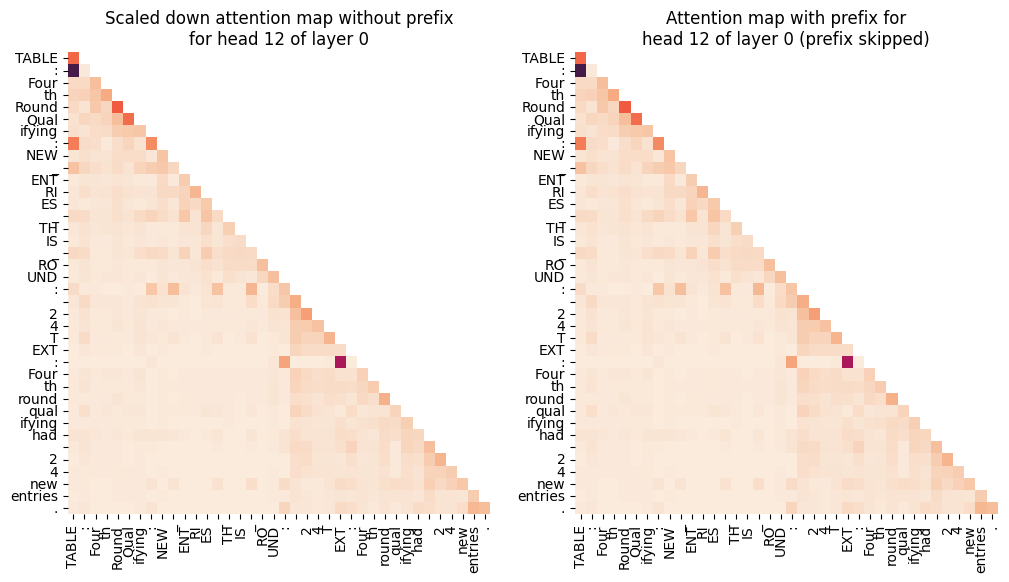

In [99]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.heatmap(
    scaled_scores, 
    vmin=0, vmax=1, 
    xticklabels=words_wo, yticklabels=words_wo,
    mask=np.triu(np.ones_like(scaled_scores), k=1), 
    ax=ax1, 
    cbar=False,
    center=0.6,
    cmap="rocket_r",
)
ax1.set_title(f"Scaled down attention map without prefix\nfor head {head_idx} of layer {layer_idx}")

sns.heatmap(
    attention_map_with[prefix_size:,prefix_size:], 
    vmin=0, vmax=1, 
    xticklabels=words_wo, yticklabels=words_wo, 
    mask=np.triu(np.ones_like(attention_map_wo), k=1),
    ax=ax2, 
    cbar=False,
    center=0.6,
    cmap="rocket_r",
)
ax2.set_title(f"Attention map with prefix for\nhead {head_idx} of layer {layer_idx} (prefix skipped)")
plt.savefig("llama_wo_prefix.pdf")
plt.show()

That concludes our verficiation of Claim 1 above, namely that the prefix cannot change the relative attention pattern across the non-prefix positions.

Now, let's check that the effect of the prefix is to simply bias the activations of the attention block in a fixed direction.
First, let's calculate the bias direction.

In [79]:
with torch.no_grad(), torch.autocast(
    device_type="cuda", dtype=torch.float16
):
    mu = prefix[layer_idx, 0]
    # need to normalize as this model uses normalization before the attention 
    mu = generator.model.layers[layer_idx].attention_norm(mu)
    # compute V mu
    wv = generator.model.layers[layer_idx].attention.wv
    vmu = wv(mu).cpu()
    # extract the part corresponding to this head
    bias_dir = vmu[head_idx*128:(head_idx+1)*128]

Now, we can check if

$$\bm t_i^\text{pt} = A_{i0}^\text{pt} V \bm\mu + (1-A_{i0}^\text{pt} ) \bm t_i =  A_{i0}^\text{pt} \ \texttt{bias\_dir} + (1-A_{i0}^\text{pt} ) \bm t_i.$$


The left-hand side is the activations with prefix tuning (`t_with`). 
The right-hand side is `t_test`.

In [85]:
t_with=activations_with_prefix[0,head_idx][1:,]
t_wo=activations_wo_prefix[0,head_idx]

Apti0 = torch.tensor(attention_map_with[prefix_size:, 0]).cpu() # the A^pt_io vector

t_test = Apti0[:, None]*bias_dir[None,:] + (1-Apti0[:, None])*t_wo

print(f"Max. absolute difference between left and right hand sight: {(t_test-t_with).abs().max().item():.2e}")

Max. absolute difference between left and right hand sight: 9.16e-05


We can also visually compare them:

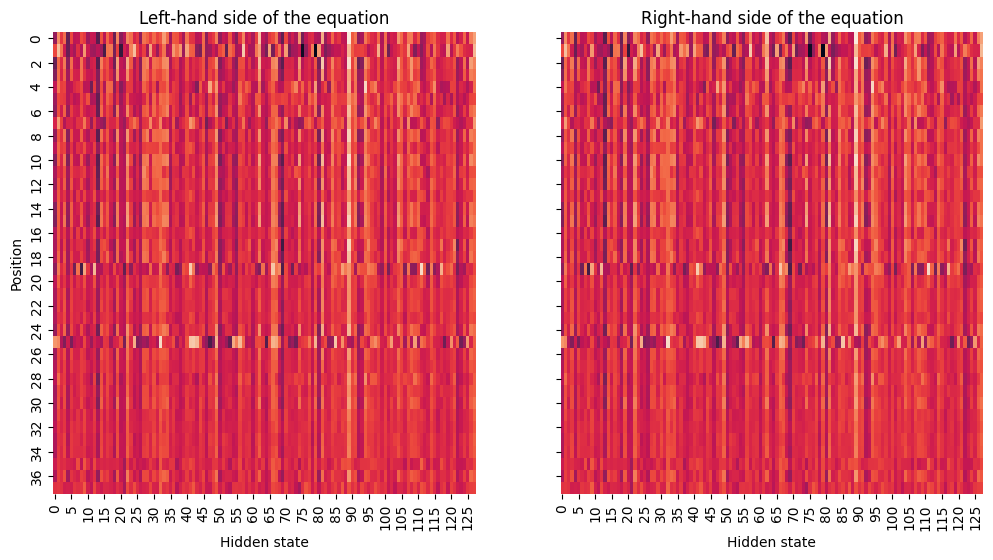

In [86]:
layer_idx = 0
head_idx = 12

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

sns.heatmap(
    t_with, 
    ax=ax1, 
    cbar=False,
)
ax1.set_title("Left-hand side of the equation")
ax1.set_ylabel("Position")
ax1.set_xlabel("Hidden state")

sns.heatmap(
    t_test, 
    ax=ax2, 
    cbar=False,
)
ax2.set_title("Right-hand side of the equation")
ax2.set_xlabel("Hidden state")
plt.show()

Therefore, indeed, the only differnce between the activations of the prefixed and the non-prefixed activations is the bias along the `bias_dir` direction.